# setup dataset

In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
# make dirs
os.makedirs("log", exist_ok=True)
os.makedirs("weights", exist_ok=True)

In [3]:
# import dataset
from utils.dataset import VOCDataset, DatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

In [4]:
## meta settings
import pretrainedmodels
model_name = 'resnet18' # choose from any resnets
DATASET = "VOC"
retina = False # for trying retinanets
fpn = False # try for fpns
HALF = False
scale = 1

In [5]:
num_class = 20 # for VOC
batch_size = 16
input_size = 512 # should be dividable with 32
MODEL_SCALE = 8 # output heatmap scale

## make data.Dataset for training

In [6]:
# load files
# set your VOCdevkit path here.
vocpath = "../VOCdevkit/VOC2007"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(vocpath)

vocpath = "../VOCdevkit/VOC2012"
train_img_list2, train_anno_list2, _, _ = make_datapath_list(vocpath)

train_img_list.extend(train_img_list2)
train_anno_list.extend(train_anno_list2)

print("trainlist: ", len(train_img_list))
print("vallist: ", len(val_img_list))

# make Dataset
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

## DatasetTransform
transform = DatasetTransform(input_size)
transform_anno = Anno_xml2list(voc_classes)

# Dataloader
train_dataset = VOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno)
val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes))

trainlist:  16551
vallist:  4952


In [7]:
# confirm operation
images, targets = val_dataset[0]

# Encode box information to heatmaps for Centernet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


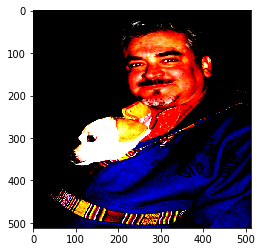

In [8]:
# show image
img = images.numpy()
plt.imshow(img.transpose(1,2,0))

In [9]:
# show targets
target = np.asarray(targets)
print(target)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T
center

[[ 0.13314448  0.478       0.54957507  0.74       11.        ]
 [ 0.01983003  0.022       0.99433428  0.994      14.        ]]


array([[ 0.34135977,  0.609     , 11.        ],
       [ 0.50708215,  0.508     , 14.        ]])

In [10]:
img -= np.min(img)

plot center points


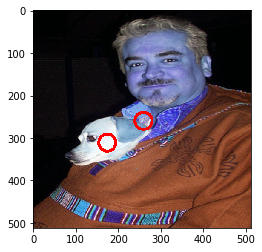

In [11]:
# Let's see if the center is encoded right

img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/000001.jpg")
img2 = cv2.resize(img2, (input_size, input_size))

# plot stuff centers
for c in center:
    img2 = cv2.circle(img2, (int(c[0]*input_size), int(c[1]*input_size)), 20, (255, 0, 0), 5)

print("plot center points")
plt.imshow(img2/255)
plt.show()
plt.imsave("imgs/center", img2/255)

The center is encoded right!

Now, we make the heatmaps so that centernet can train to predict centers.

In [12]:
# from centernet repo
def draw_msra_gaussian(heatmap, center, sigma=3):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

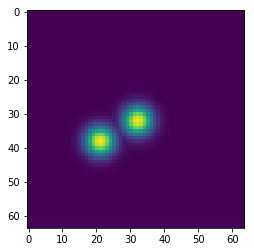

In [13]:
# make output heatmap for single class
hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                     np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T

# make a center point
# try gaussian points.
for c in center:
    #hm[int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE] = 1
    hm = draw_msra_gaussian(hm, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
    
# plot and confirm if its working
plt.imshow(hm)
plt.show()

### make output heatmap for each class

heatmap of person class


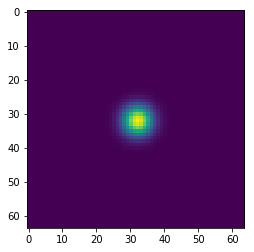

In [14]:
hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                     np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T

# make a center point
# try gaussian points.
for c in center:
    mask = hm[int(c[2]), :, :]
    mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
    hm[int(c[2]), :, :] = mask
    
# plot and confirm if its working
print("heatmap of person class")
plt.imshow(hm[14])
plt.show()

### make regression targets.

[[ 0.13314448  0.478       0.54957507  0.74       11.        ]
 [ 0.01983003  0.022       0.99433428  0.994      14.        ]]
show regr


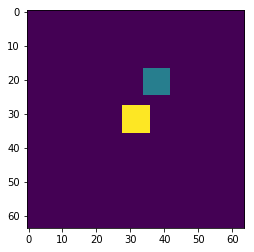

In [15]:
# [width_size, height_size]

# make regr heatmap 
regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
print(target)
# convert targets to its center.
regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

# plot regr values to mask
for r, c in zip(regrs, center):
    y, x = int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE
    for i in range(-4, 4):
        for j in range(-4, 4):
            regr[:, int(c[0]*input_size)//MODEL_SCALE+i, int(c[1]*input_size)//MODEL_SCALE+j] = r
    #regr = draw_dense_reg(regr, center, [y,x], regrs, 0, False)

print("show regr")
plt.imshow(regr[0])
plt.show()

In [16]:
regr.shape

(2, 64, 64)

In [17]:
# wrap as function
def make_hm(target, input_size=512, num_class=20):
    # make output heatmap for each class
    hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

    # convert targets to its center.
    center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                         np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T
    regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

    # make masks
    for r, c in zip(regrs, center):
        mask = hm[int(c[2]), :, :]
        mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
        hm[int(c[2]), :, :] = mask
        for i in range(-4, 4):
            for j in range(-4, 4):
                xx = np.clip(int(c[0]*input_size)//MODEL_SCALE+i, 0, 63)
                yy = np.clip(int(c[1]*input_size)//MODEL_SCALE+j, 0, 63)
                regr[:, xx, yy] = r
    return hm, regr

# define dataloaders

In [18]:
class centerVOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno, input_size=512):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
        self.input_size = input_size
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        im, hm, regr = self.pull_item(index)
        #print(im.shape)
        #print(hm.shape)
        #print(regr.shape)
        return im, hm, regr
    
    def pull_item(self, index):
        # 1. read image
        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        height, width, channel = img.shape
        
        # 2. read annotations
        xml_path = self.anno_list[index]
        anno_list = self.transform_anno(xml_path, width, height)
        
        # 3. augumentations
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        # 4. transform BGR to RGB
        img = torch.from_numpy(img[:, :, (2, 1, 0)])
        img = img.permute(2, 0, 1)
        
        # 5. convert boxes inforatmion to heatmaps
        hm, regr = make_hm(gt, self.input_size)
        
        return img, hm, regr

In [19]:
# test dataloader
# call dataset
train_dataset2 = centerVOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno, input_size=input_size)
val_dataset2 = centerVOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes), input_size=input_size)

# dataloader
train_dataloader = data.DataLoader(
    train_dataset2, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = data.DataLoader(
    val_dataset2, batch_size=batch_size, shuffle=False, num_workers=8)
# as dict
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


im


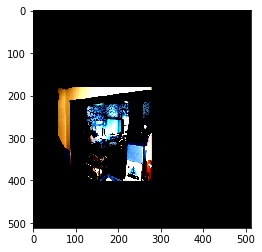

heatmap


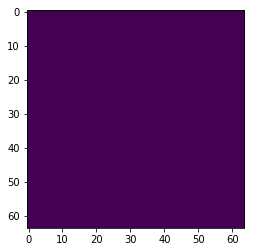

regr


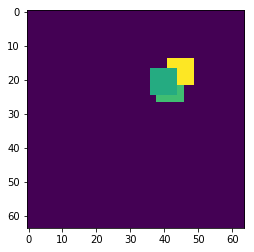

In [20]:
# confirm operation
im, hm, regr = train_dataset2[0]
print("im")
plt.imshow(im.numpy().transpose(1,2,0))
plt.show()
print("heatmap")
plt.imshow(hm[14])
plt.show()
print("regr")
plt.imshow(regr[0])
plt.show()

In [21]:
im.shape

torch.Size([3, 512, 512])

In [22]:
np.concatenate([hm,regr]).shape

(22, 64, 64)

# define Centernet model and test

In [23]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# create backbone.
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

In [25]:
class centernet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(centernet, self).__init__()
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        #x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [26]:
# test if net works
model = centernet(num_class) # +2 for width and height regressions
print(torch.rand([1,3,input_size,input_size]).size())
outc, outr = model(torch.rand([1,3,input_size,input_size]))
print(outc.size())
print(outr.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 20, 64, 64])
torch.Size([1, 2, 64, 64])


# set up optimizers

In [27]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## setup focal loss

In [28]:
# focal loss
def neg_loss(pred, gt):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
  '''
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 2) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 2) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss

def criterion(pred_mask, pred_regr, mask, regr, weight=0.4, size_average=True, num_class=20):
    # Binary mask loss
    pred_mask = torch.sigmoid(pred_mask) # class masks
    mask_loss = neg_loss(pred_mask, mask)
    
    sum=np.sum(mask.cpu().numpy()==1)
    
    # Regression L1 loss
    #print(pred_regr.size())
    #print(regr.size())
    regr_loss = _reg_loss(pred_regr, regr, mask)
    #regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask.sum(1)).sum(1).sum(1) / mask.sum(1).sum(1).sum(1)
    #regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss * 10
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [29]:
# while the original efficientdet uses cosine annealining lr scheduling, we utilize epoch-based lr decreasing for simplicity.
def get_current_lr(epoch): 
    reduce = [80,120]
    lr = 1e-3
        
    for i,lr_decay_epoch in enumerate(reduce):
        if epoch >= lr_decay_epoch:
            lr *= 0.1
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    print("lr is:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [30]:
# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))
            
            for c1 in range(3):
                for c2 in range(3):
                    #print(c1,c2)
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

# set up train and eval scripts

In [31]:
# train script. nothing special..
import gc
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("used device:", device)

    # ネットワークをGPUへ
    model.to(device)
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):
        
        adjust_learning_rate(optimizer, epoch)
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
                print('(train)')
            else:
                if((epoch+1) % 2 == 0):
                    model.eval()   # モデルを検証モードに
                    print('-------------')
                    print('(val)')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, hm, regr in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                hm = hm.to(device)
                regr = regr.to(device)
                
                if HALF:
                    images = images.half()
                    targets = [ann.half() for ann in targets]
                    
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    mask, mask_regr = model(images)
                    #print(outputs[0].type())
                    # 損失の計算
                    loss, mask_loss, regr_loss = criterion(mask, mask_regr, hm, regr)

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            model.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('Iter {} || Loss: {:.4f} || Mask: {:.4f} || Regr: {:.4f}'.format(
                                iteration, loss.item(), mask_loss.item(), regr_loss.item()))
                            t_iter_start = time.time()
                        # filter inf..
                        if not loss.item() == float("inf"):
                            epoch_train_loss += loss.item()
                        iteration += 1
                        
                        if iteration%100 == 0:
                            id = 0
                            img, hm, regr = val_dataset2[id]
                            img = img.to(device).unsqueeze(0)
                            with torch.no_grad():
                                hm, regr = model(img)
                            hm = hm.cpu().numpy();regr = regr.cpu().numpy()
                            plt.imshow(hm[0,14])
                            plt.show()
                            plt.imshow(hm[0,14]>0)
                            plt.show()
                            plt.imshow(regr[0,0])
                            plt.show()

                    # 検証時
                    else:
                        if not loss.item() == float("inf"):
                            epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log/"+DATASET+"_"+model_name+"_" + str(input_size) +"log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        gc.collect()

        # ネットワークを保存する
        if((epoch+1) % 10 == 0):
            torch.save(model.state_dict(), 'weights/'+DATASET+"_"+model_name+"_" + str(input_size) + "_" + 
                       str(epoch+1) + '.pth')


used device: cuda:0
lr is: 0.001
-------------
Epoch 1/150
-------------
(train)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iter 10 || Loss: 1181.3380 || Mask: 1181.1641 || Regr: 0.0174
Iter 20 || Loss: 64.2316 || Mask: 63.4954 || Regr: 0.0736
Iter 30 || Loss: 5.7560 || Mask: 5.4838 || Regr: 0.0272
Iter 40 || Loss: 4.4272 || Mask: 4.0107 || Regr: 0.0416
Iter 50 || Loss: 4.5310 || Mask: 3.9964 || Regr: 0.0535
Iter 60 || Loss: 4.6026 || Mask: 3.9673 || Regr: 0.0635
Iter 70 || Loss: 3.9247 || Mask: 3.7865 || Regr: 0.0138
Iter 80 || Loss: 4.2906 || Mask: 3.9117 || Regr: 0.0379
Iter 90 || Loss: 4.2118 || Mask: 3.9092 || Regr: 0.0303


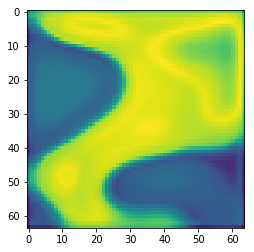

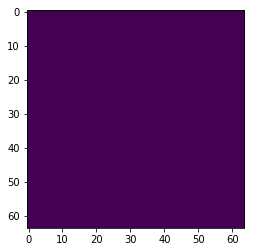

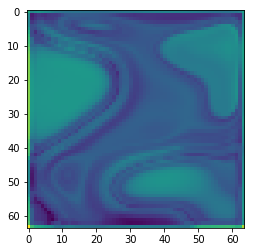

Iter 100 || Loss: 4.3320 || Mask: 3.8646 || Regr: 0.0467
Iter 110 || Loss: 4.3092 || Mask: 3.9361 || Regr: 0.0373
Iter 120 || Loss: 4.4104 || Mask: 4.1631 || Regr: 0.0247
Iter 130 || Loss: 3.6929 || Mask: 3.6179 || Regr: 0.0075
Iter 140 || Loss: 4.0962 || Mask: 3.6751 || Regr: 0.0421
Iter 150 || Loss: 4.1195 || Mask: 3.8411 || Regr: 0.0278
Iter 160 || Loss: 4.6199 || Mask: 3.9450 || Regr: 0.0675
Iter 170 || Loss: 3.7151 || Mask: 3.4982 || Regr: 0.0217
Iter 180 || Loss: 4.2105 || Mask: 3.9053 || Regr: 0.0305
Iter 190 || Loss: 4.9984 || Mask: 3.8894 || Regr: 0.1109


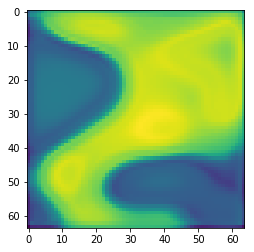

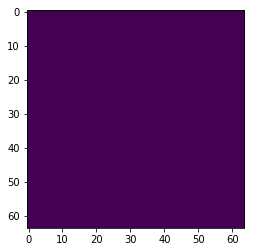

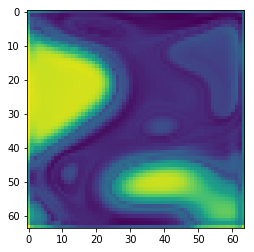

Iter 200 || Loss: 4.1410 || Mask: 3.8464 || Regr: 0.0295
Iter 210 || Loss: 4.1355 || Mask: 3.7224 || Regr: 0.0413
Iter 220 || Loss: 3.8337 || Mask: 3.5929 || Regr: 0.0241
Iter 230 || Loss: 3.8632 || Mask: 3.6207 || Regr: 0.0242
Iter 240 || Loss: 4.4090 || Mask: 3.9740 || Regr: 0.0435
Iter 250 || Loss: 3.4863 || Mask: 3.2915 || Regr: 0.0195
Iter 260 || Loss: 4.2348 || Mask: 3.6451 || Regr: 0.0590
Iter 270 || Loss: 3.8975 || Mask: 3.5561 || Regr: 0.0341
Iter 280 || Loss: 4.2954 || Mask: 3.9553 || Regr: 0.0340
Iter 290 || Loss: 4.1203 || Mask: 3.6940 || Regr: 0.0426


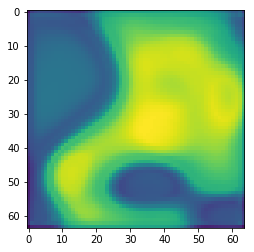

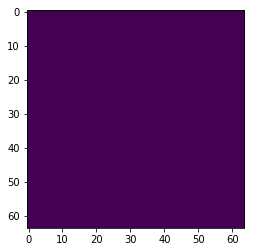

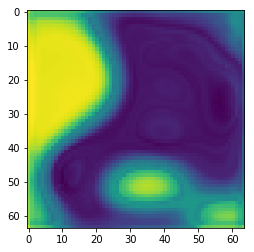

Iter 300 || Loss: 3.9764 || Mask: 3.5975 || Regr: 0.0379
Iter 310 || Loss: 4.0338 || Mask: 3.7293 || Regr: 0.0304
Iter 320 || Loss: 4.0078 || Mask: 3.7541 || Regr: 0.0254
Iter 330 || Loss: 4.4817 || Mask: 4.2668 || Regr: 0.0215
Iter 340 || Loss: 4.4651 || Mask: 3.8367 || Regr: 0.0628
Iter 350 || Loss: 3.9630 || Mask: 3.7113 || Regr: 0.0252
Iter 360 || Loss: 4.0332 || Mask: 3.6418 || Regr: 0.0391
Iter 370 || Loss: 4.5634 || Mask: 3.8551 || Regr: 0.0708
Iter 380 || Loss: 4.2273 || Mask: 3.7052 || Regr: 0.0522
Iter 390 || Loss: 4.1697 || Mask: 3.6116 || Regr: 0.0558


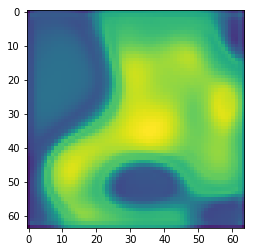

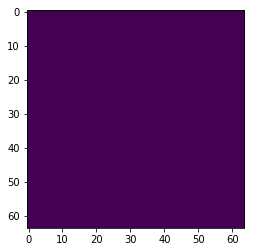

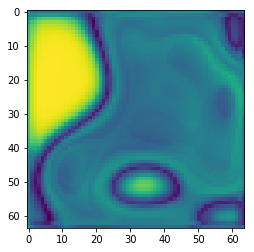

Iter 400 || Loss: 4.1314 || Mask: 3.8412 || Regr: 0.0290
Iter 410 || Loss: 4.0653 || Mask: 3.5150 || Regr: 0.0550
Iter 420 || Loss: 3.5691 || Mask: 3.3269 || Regr: 0.0242
Iter 430 || Loss: 4.0100 || Mask: 3.6509 || Regr: 0.0359
Iter 440 || Loss: 3.7221 || Mask: 3.5061 || Regr: 0.0216
Iter 450 || Loss: 3.9481 || Mask: 3.6939 || Regr: 0.0254
Iter 460 || Loss: 4.4959 || Mask: 3.9202 || Regr: 0.0576
Iter 470 || Loss: 4.2700 || Mask: 3.8664 || Regr: 0.0404
Iter 480 || Loss: 3.9421 || Mask: 3.5309 || Regr: 0.0411
Iter 490 || Loss: 3.6254 || Mask: 3.4317 || Regr: 0.0194


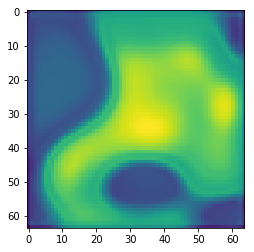

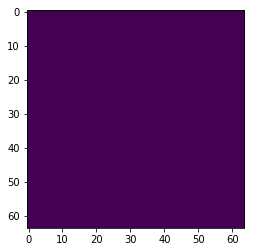

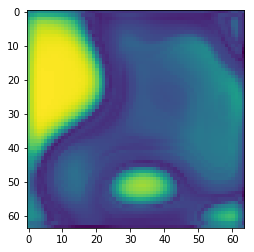

Iter 500 || Loss: 4.1310 || Mask: 3.7368 || Regr: 0.0394
Iter 510 || Loss: 3.4063 || Mask: 3.2593 || Regr: 0.0147
Iter 520 || Loss: 4.0594 || Mask: 3.6468 || Regr: 0.0413
Iter 530 || Loss: 4.4192 || Mask: 3.8547 || Regr: 0.0564
Iter 540 || Loss: 4.5714 || Mask: 3.8465 || Regr: 0.0725
Iter 550 || Loss: 3.7127 || Mask: 3.4634 || Regr: 0.0249
Iter 560 || Loss: 3.3996 || Mask: 3.1591 || Regr: 0.0240
Iter 570 || Loss: 3.5160 || Mask: 3.2284 || Regr: 0.0288
Iter 580 || Loss: 3.5684 || Mask: 3.3278 || Regr: 0.0241
Iter 590 || Loss: 3.6157 || Mask: 3.4871 || Regr: 0.0129


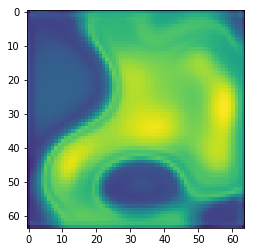

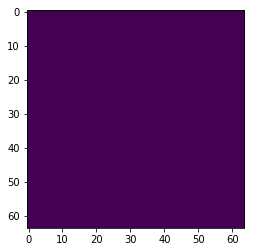

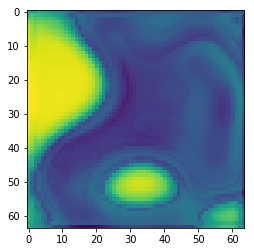

Iter 600 || Loss: 3.7208 || Mask: 3.6066 || Regr: 0.0114
Iter 610 || Loss: 3.8388 || Mask: 3.5487 || Regr: 0.0290
Iter 620 || Loss: 3.6143 || Mask: 3.3040 || Regr: 0.0310
Iter 630 || Loss: 3.6023 || Mask: 3.2974 || Regr: 0.0305
Iter 640 || Loss: 3.4086 || Mask: 3.3153 || Regr: 0.0093
Iter 650 || Loss: 4.2026 || Mask: 3.6213 || Regr: 0.0581
Iter 660 || Loss: 4.0225 || Mask: 3.6680 || Regr: 0.0355
Iter 670 || Loss: 3.6341 || Mask: 3.4350 || Regr: 0.0199
Iter 680 || Loss: 3.6560 || Mask: 3.4222 || Regr: 0.0234
Iter 690 || Loss: 3.6128 || Mask: 3.2393 || Regr: 0.0373


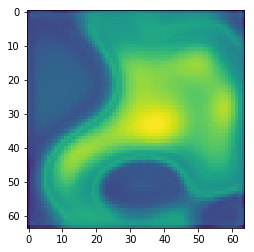

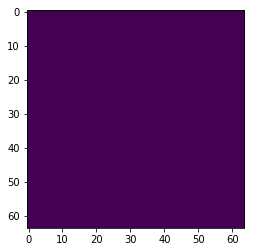

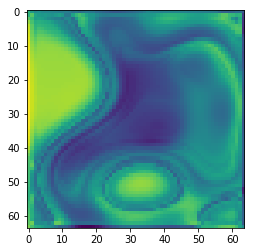

Iter 700 || Loss: 3.1125 || Mask: 3.0241 || Regr: 0.0088
Iter 710 || Loss: 3.8441 || Mask: 3.4297 || Regr: 0.0414
Iter 720 || Loss: 3.8803 || Mask: 3.4217 || Regr: 0.0459
Iter 730 || Loss: 3.9907 || Mask: 3.6831 || Regr: 0.0308
Iter 740 || Loss: 3.8816 || Mask: 3.6388 || Regr: 0.0243
Iter 750 || Loss: 3.4651 || Mask: 3.1475 || Regr: 0.0318
Iter 760 || Loss: 3.8229 || Mask: 3.5856 || Regr: 0.0237
Iter 770 || Loss: 3.9134 || Mask: 3.5553 || Regr: 0.0358
Iter 780 || Loss: 3.5094 || Mask: 3.1621 || Regr: 0.0347
Iter 790 || Loss: 3.8163 || Mask: 3.6257 || Regr: 0.0191


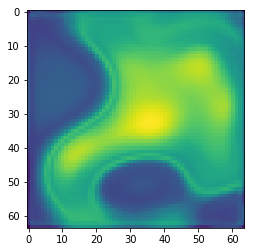

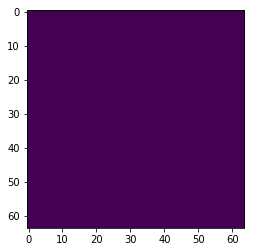

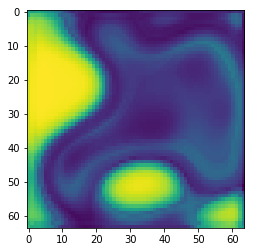

Iter 800 || Loss: 3.8622 || Mask: 3.6691 || Regr: 0.0193
Iter 810 || Loss: 3.7968 || Mask: 3.4240 || Regr: 0.0373
Iter 820 || Loss: 3.5498 || Mask: 3.3427 || Regr: 0.0207
Iter 830 || Loss: 4.0771 || Mask: 3.2140 || Regr: 0.0863
Iter 840 || Loss: 3.9865 || Mask: 3.6773 || Regr: 0.0309
Iter 850 || Loss: 3.8845 || Mask: 3.5941 || Regr: 0.0290
Iter 860 || Loss: 3.4837 || Mask: 3.1993 || Regr: 0.0284
Iter 870 || Loss: 3.3970 || Mask: 3.1394 || Regr: 0.0258
Iter 880 || Loss: 3.1615 || Mask: 2.8699 || Regr: 0.0292
Iter 890 || Loss: 3.3720 || Mask: 3.1943 || Regr: 0.0178


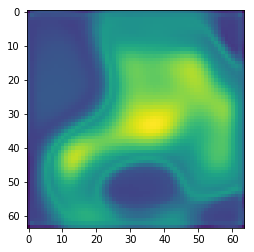

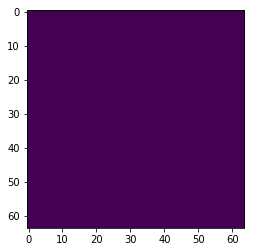

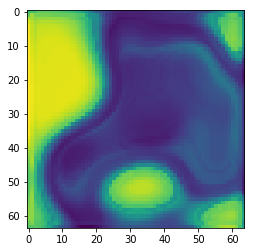

Iter 900 || Loss: 4.0811 || Mask: 3.8221 || Regr: 0.0259
Iter 910 || Loss: 3.5606 || Mask: 3.3764 || Regr: 0.0184
Iter 920 || Loss: 4.1325 || Mask: 3.9503 || Regr: 0.0182
Iter 930 || Loss: 3.4866 || Mask: 3.2501 || Regr: 0.0236
Iter 940 || Loss: 3.9601 || Mask: 3.7088 || Regr: 0.0251
Iter 950 || Loss: 3.2780 || Mask: 3.1688 || Regr: 0.0109
Iter 960 || Loss: 3.3629 || Mask: 3.1573 || Regr: 0.0206
Iter 970 || Loss: 4.2673 || Mask: 3.9722 || Regr: 0.0295
Iter 980 || Loss: 3.7424 || Mask: 3.5246 || Regr: 0.0218
Iter 990 || Loss: 3.7351 || Mask: 3.2996 || Regr: 0.0436


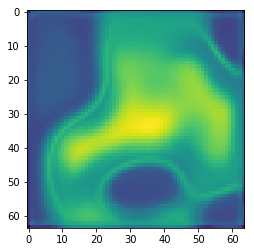

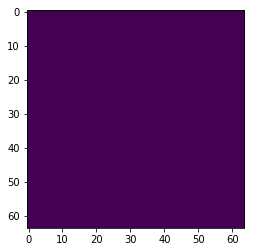

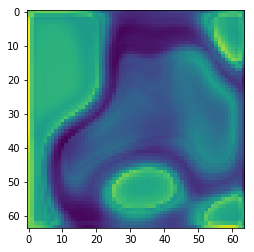

Iter 1000 || Loss: 3.5542 || Mask: 3.2871 || Regr: 0.0267
Iter 1010 || Loss: 3.6285 || Mask: 3.4420 || Regr: 0.0186
Iter 1020 || Loss: 3.5804 || Mask: 3.0711 || Regr: 0.0509
Iter 1030 || Loss: 3.5833 || Mask: 3.2602 || Regr: 0.0323

-------------
epoch 1 || Epoch_TRAIN_Loss:52695.3868 ||Epoch_VAL_Loss:0.0000
timer:  286.6220 sec.
lr is: 0.001
-------------
Epoch 2/150
-------------
(train)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iter 1040 || Loss: 3.7183 || Mask: 3.4146 || Regr: 0.0304
Iter 1050 || Loss: 3.5521 || Mask: 3.2681 || Regr: 0.0284
Iter 1060 || Loss: 3.7899 || Mask: 3.3888 || Regr: 0.0401
Iter 1070 || Loss: 3.7890 || Mask: 3.4697 || Regr: 0.0319
Iter 1080 || Loss: 3.4255 || Mask: 3.2441 || Regr: 0.0181
Iter 1090 || Loss: 3.4938 || Mask: 3.3739 || Regr: 0.0120


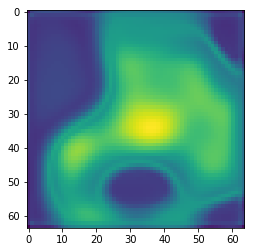

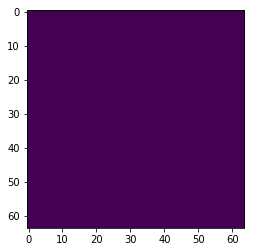

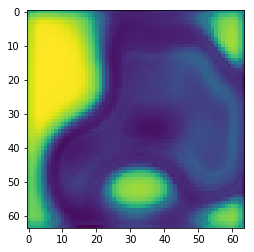

Iter 1100 || Loss: 3.5388 || Mask: 3.4197 || Regr: 0.0119
Iter 1110 || Loss: 3.4632 || Mask: 3.0941 || Regr: 0.0369
Iter 1120 || Loss: 3.3232 || Mask: 3.1420 || Regr: 0.0181
Iter 1130 || Loss: 3.6326 || Mask: 3.3791 || Regr: 0.0254
Iter 1140 || Loss: 4.3493 || Mask: 3.8733 || Regr: 0.0476
Iter 1150 || Loss: 3.8483 || Mask: 3.2716 || Regr: 0.0577
Iter 1160 || Loss: 3.7895 || Mask: 3.5861 || Regr: 0.0203
Iter 1170 || Loss: 3.7272 || Mask: 3.4940 || Regr: 0.0233
Iter 1180 || Loss: 4.1282 || Mask: 3.6768 || Regr: 0.0451
Iter 1190 || Loss: 3.2740 || Mask: 3.0250 || Regr: 0.0249


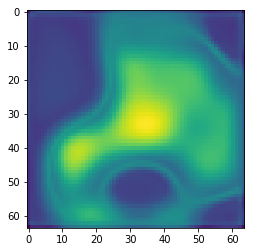

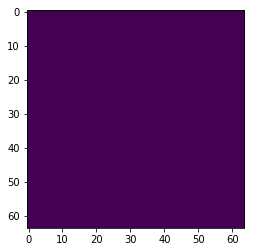

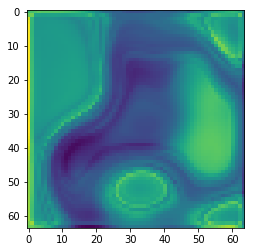

Iter 1200 || Loss: 3.9504 || Mask: 3.5489 || Regr: 0.0402
Iter 1210 || Loss: 3.6669 || Mask: 3.4648 || Regr: 0.0202
Iter 1220 || Loss: 3.6560 || Mask: 3.3190 || Regr: 0.0337
Iter 1230 || Loss: 4.0271 || Mask: 3.5181 || Regr: 0.0509
Iter 1240 || Loss: 3.6397 || Mask: 3.2524 || Regr: 0.0387
Iter 1250 || Loss: 4.0898 || Mask: 3.4803 || Regr: 0.0609
Iter 1260 || Loss: 3.8418 || Mask: 3.4688 || Regr: 0.0373
Iter 1270 || Loss: 3.1091 || Mask: 2.9230 || Regr: 0.0186
Iter 1280 || Loss: 4.1628 || Mask: 3.7674 || Regr: 0.0395
Iter 1290 || Loss: 3.8024 || Mask: 3.4715 || Regr: 0.0331


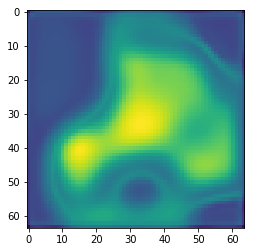

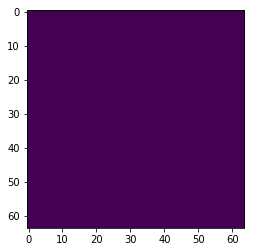

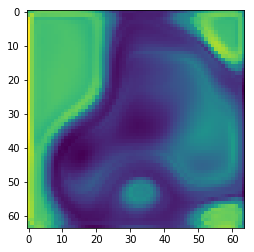

Iter 1300 || Loss: 3.5243 || Mask: 3.1980 || Regr: 0.0326
Iter 1310 || Loss: 3.5996 || Mask: 3.4673 || Regr: 0.0132
Iter 1320 || Loss: 3.8573 || Mask: 3.3831 || Regr: 0.0474
Iter 1330 || Loss: 4.2003 || Mask: 3.6126 || Regr: 0.0588
Iter 1340 || Loss: 3.7812 || Mask: 3.3928 || Regr: 0.0388
Iter 1350 || Loss: 3.8991 || Mask: 3.6120 || Regr: 0.0287
Iter 1360 || Loss: 3.7784 || Mask: 3.2974 || Regr: 0.0481
Iter 1370 || Loss: 3.0934 || Mask: 2.9437 || Regr: 0.0150
Iter 1380 || Loss: 3.2448 || Mask: 3.1293 || Regr: 0.0116
Iter 1390 || Loss: 4.0496 || Mask: 3.6646 || Regr: 0.0385


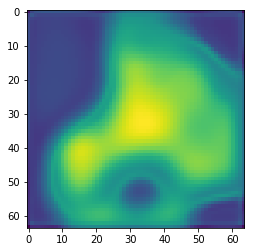

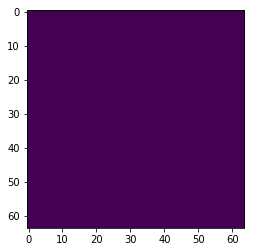

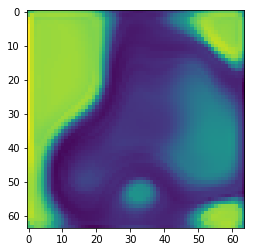

Iter 1400 || Loss: 3.4321 || Mask: 3.0859 || Regr: 0.0346
Iter 1410 || Loss: 3.9035 || Mask: 3.4435 || Regr: 0.0460
Iter 1420 || Loss: 3.5874 || Mask: 3.1899 || Regr: 0.0398
Iter 1430 || Loss: 4.1487 || Mask: 3.5380 || Regr: 0.0611
Iter 1440 || Loss: 3.5250 || Mask: 3.1518 || Regr: 0.0373
Iter 1450 || Loss: 2.8597 || Mask: 2.6235 || Regr: 0.0236
Iter 1460 || Loss: 3.8589 || Mask: 3.5188 || Regr: 0.0340
Iter 1470 || Loss: 3.4665 || Mask: 2.7792 || Regr: 0.0687
Iter 1480 || Loss: 3.2702 || Mask: 3.1296 || Regr: 0.0141
Iter 1490 || Loss: 3.8961 || Mask: 3.6427 || Regr: 0.0253


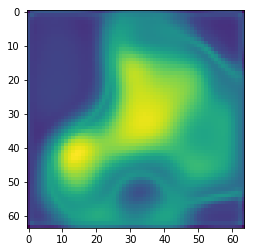

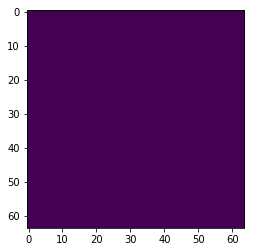

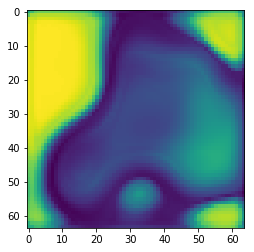

Iter 1500 || Loss: 3.9503 || Mask: 3.5389 || Regr: 0.0411
Iter 1510 || Loss: 3.8134 || Mask: 3.4140 || Regr: 0.0399
Iter 1520 || Loss: 3.4531 || Mask: 3.1865 || Regr: 0.0267
Iter 1530 || Loss: 3.3681 || Mask: 3.1163 || Regr: 0.0252
Iter 1540 || Loss: 3.7702 || Mask: 3.6193 || Regr: 0.0151
Iter 1550 || Loss: 3.5622 || Mask: 3.3061 || Regr: 0.0256
Iter 1560 || Loss: 2.8323 || Mask: 2.6593 || Regr: 0.0173
Iter 1570 || Loss: 3.4674 || Mask: 3.3053 || Regr: 0.0162
Iter 1580 || Loss: 3.4948 || Mask: 3.1888 || Regr: 0.0306
Iter 1590 || Loss: 4.1085 || Mask: 3.5363 || Regr: 0.0572


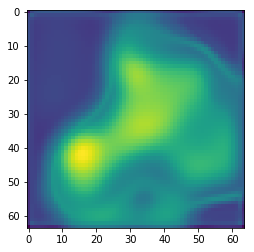

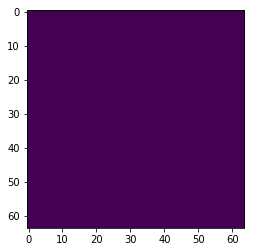

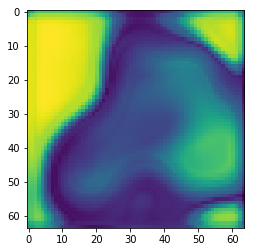

Iter 1600 || Loss: 3.6562 || Mask: 3.5115 || Regr: 0.0145
Iter 1610 || Loss: 3.4084 || Mask: 3.0976 || Regr: 0.0311
Iter 1620 || Loss: 3.4126 || Mask: 3.2567 || Regr: 0.0156
Iter 1630 || Loss: 3.3277 || Mask: 2.8742 || Regr: 0.0454
Iter 1640 || Loss: 4.0953 || Mask: 3.6455 || Regr: 0.0450
Iter 1650 || Loss: 3.7458 || Mask: 3.3616 || Regr: 0.0384
Iter 1660 || Loss: 3.8413 || Mask: 3.5401 || Regr: 0.0301
Iter 1670 || Loss: 3.7481 || Mask: 3.2263 || Regr: 0.0522
Iter 1680 || Loss: 3.8802 || Mask: 3.2451 || Regr: 0.0635
Iter 1690 || Loss: 3.6337 || Mask: 3.3996 || Regr: 0.0234


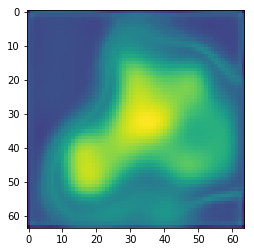

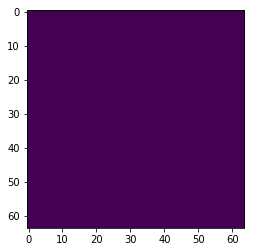

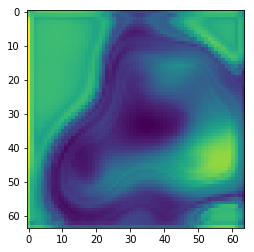

Iter 1700 || Loss: 3.7732 || Mask: 3.3281 || Regr: 0.0445
Iter 1710 || Loss: 3.6692 || Mask: 3.2860 || Regr: 0.0383
Iter 1720 || Loss: 3.3627 || Mask: 3.1153 || Regr: 0.0247
Iter 1730 || Loss: 3.3863 || Mask: 3.0137 || Regr: 0.0373
Iter 1740 || Loss: 3.7866 || Mask: 3.6007 || Regr: 0.0186
Iter 1750 || Loss: 3.6078 || Mask: 3.3450 || Regr: 0.0263
Iter 1760 || Loss: 3.1035 || Mask: 2.9136 || Regr: 0.0190
Iter 1770 || Loss: 3.9410 || Mask: 3.5204 || Regr: 0.0421
Iter 1780 || Loss: 4.3089 || Mask: 3.7222 || Regr: 0.0587
Iter 1790 || Loss: 2.9793 || Mask: 2.8621 || Regr: 0.0117


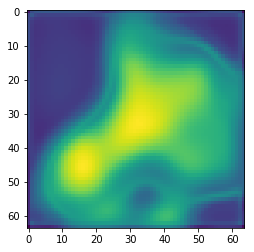

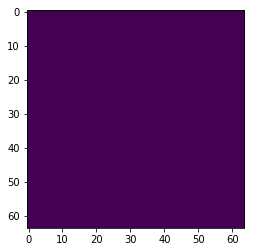

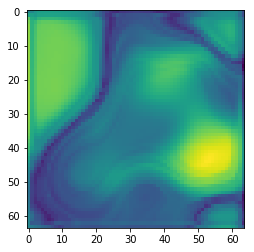

Iter 1800 || Loss: 3.1540 || Mask: 2.9520 || Regr: 0.0202
Iter 1810 || Loss: 3.4853 || Mask: 3.2878 || Regr: 0.0197
Iter 1820 || Loss: 3.7422 || Mask: 3.4674 || Regr: 0.0275
Iter 1830 || Loss: 3.0427 || Mask: 2.5215 || Regr: 0.0521
Iter 1840 || Loss: 3.3990 || Mask: 3.1490 || Regr: 0.0250
Iter 1850 || Loss: 3.1073 || Mask: 2.8763 || Regr: 0.0231
Iter 1860 || Loss: 3.1875 || Mask: 3.0293 || Regr: 0.0158
Iter 1870 || Loss: 3.3929 || Mask: 3.1272 || Regr: 0.0266
Iter 1880 || Loss: 3.2593 || Mask: 3.0047 || Regr: 0.0255
Iter 1890 || Loss: 3.8057 || Mask: 3.4242 || Regr: 0.0381


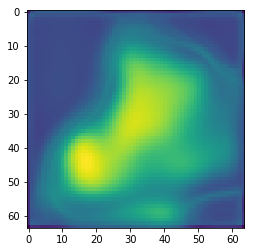

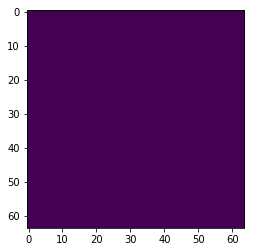

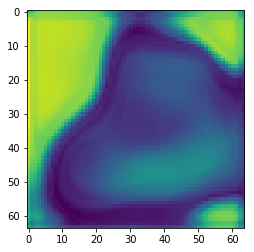

Iter 1900 || Loss: 3.4036 || Mask: 3.1938 || Regr: 0.0210
Iter 1910 || Loss: 4.0299 || Mask: 3.3698 || Regr: 0.0660
Iter 1920 || Loss: 3.5787 || Mask: 3.3104 || Regr: 0.0268
Iter 1930 || Loss: 3.5228 || Mask: 3.2667 || Regr: 0.0256
Iter 1940 || Loss: 3.6200 || Mask: 3.3384 || Regr: 0.0282
Iter 1950 || Loss: 3.1857 || Mask: 2.8891 || Regr: 0.0297
Iter 1960 || Loss: 4.2374 || Mask: 3.5557 || Regr: 0.0682
Iter 1970 || Loss: 4.0111 || Mask: 3.4547 || Regr: 0.0556
Iter 1980 || Loss: 3.0173 || Mask: 2.8783 || Regr: 0.0139
Iter 1990 || Loss: 2.9039 || Mask: 2.7172 || Regr: 0.0187


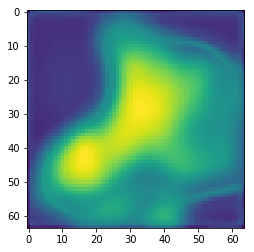

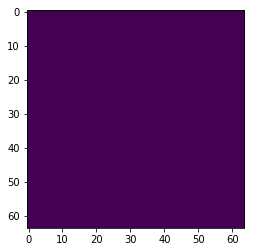

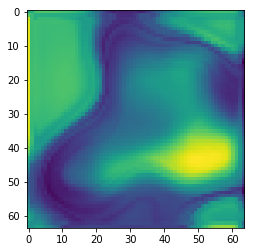

Iter 2000 || Loss: 3.1975 || Mask: 2.9568 || Regr: 0.0241
Iter 2010 || Loss: 3.6486 || Mask: 3.3198 || Regr: 0.0329
Iter 2020 || Loss: 3.4109 || Mask: 3.0241 || Regr: 0.0387
Iter 2030 || Loss: 2.8062 || Mask: 2.6891 || Regr: 0.0117
Iter 2040 || Loss: 3.2296 || Mask: 3.0051 || Regr: 0.0225
Iter 2050 || Loss: 2.7850 || Mask: 2.6529 || Regr: 0.0132
Iter 2060 || Loss: 3.4090 || Mask: 3.0230 || Regr: 0.0386
Iter 2070 || Loss: 4.9263 || Mask: 3.0228 || Regr: 0.1903

-------------
(val)



-------------
epoch 2 || Epoch_TRAIN_Loss:3712.5554 ||Epoch_VAL_Loss:1113.2697
timer:  326.9639 sec.
lr is: 0.001
-------------
Epoch 3/150
-------------
(train)


Iter 2080 || Loss: 3.3199 || Mask: 3.0431 || Regr: 0.0277
Iter 2090 || Loss: 3.1994 || Mask: 2.8248 || Regr: 0.0375


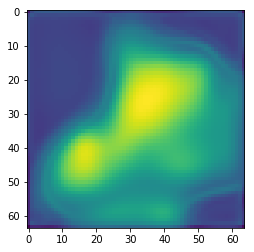

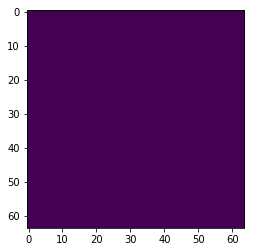

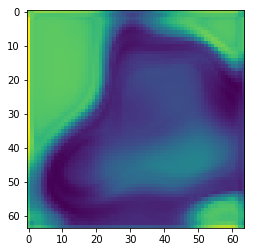

Iter 2100 || Loss: 3.0938 || Mask: 2.8970 || Regr: 0.0197
Iter 2110 || Loss: 3.7282 || Mask: 3.3017 || Regr: 0.0426
Iter 2120 || Loss: 2.9359 || Mask: 2.8525 || Regr: 0.0083
Iter 2130 || Loss: 3.4541 || Mask: 3.0270 || Regr: 0.0427
Iter 2140 || Loss: 3.3879 || Mask: 3.1353 || Regr: 0.0253
Iter 2150 || Loss: 3.2722 || Mask: 3.0231 || Regr: 0.0249
Iter 2160 || Loss: 3.2870 || Mask: 3.0000 || Regr: 0.0287
Iter 2170 || Loss: 2.9645 || Mask: 2.8041 || Regr: 0.0160
Iter 2180 || Loss: 3.2400 || Mask: 2.9038 || Regr: 0.0336
Iter 2190 || Loss: 3.6150 || Mask: 3.3094 || Regr: 0.0306


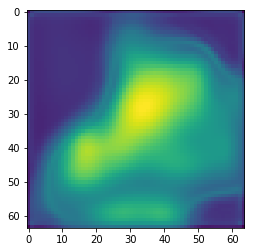

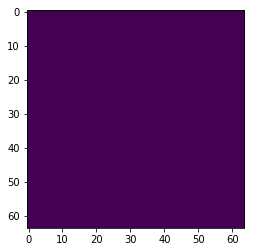

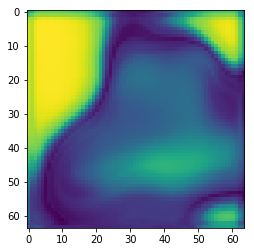

Iter 2200 || Loss: 3.0271 || Mask: 2.8714 || Regr: 0.0156
Iter 2210 || Loss: 3.0668 || Mask: 2.8033 || Regr: 0.0263
Iter 2220 || Loss: 3.3598 || Mask: 3.2017 || Regr: 0.0158
Iter 2230 || Loss: 3.7496 || Mask: 3.4554 || Regr: 0.0294
Iter 2240 || Loss: 2.8725 || Mask: 2.7011 || Regr: 0.0171
Iter 2250 || Loss: 3.4560 || Mask: 3.0947 || Regr: 0.0361
Iter 2260 || Loss: 2.9595 || Mask: 2.7705 || Regr: 0.0189
Iter 2270 || Loss: 3.5547 || Mask: 3.3006 || Regr: 0.0254
Iter 2280 || Loss: 3.9479 || Mask: 3.4043 || Regr: 0.0544
Iter 2290 || Loss: 3.6534 || Mask: 3.4201 || Regr: 0.0233


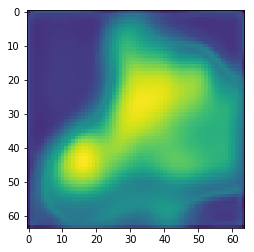

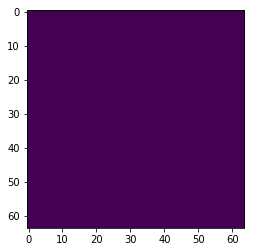

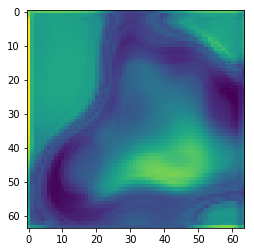

Iter 2300 || Loss: 3.4531 || Mask: 3.0317 || Regr: 0.0421
Iter 2310 || Loss: 4.5113 || Mask: 3.6980 || Regr: 0.0813
Iter 2320 || Loss: 3.2122 || Mask: 2.9895 || Regr: 0.0223
Iter 2330 || Loss: 3.6439 || Mask: 3.1484 || Regr: 0.0495
Iter 2340 || Loss: 3.4841 || Mask: 3.3502 || Regr: 0.0134
Iter 2350 || Loss: 3.2677 || Mask: 3.0499 || Regr: 0.0218
Iter 2360 || Loss: 3.4432 || Mask: 3.0344 || Regr: 0.0409
Iter 2370 || Loss: 3.1695 || Mask: 2.9640 || Regr: 0.0205
Iter 2380 || Loss: 3.4806 || Mask: 3.0388 || Regr: 0.0442
Iter 2390 || Loss: 2.9995 || Mask: 2.8122 || Regr: 0.0187


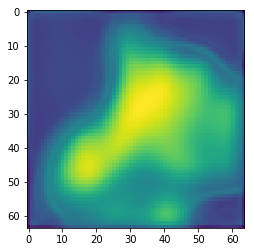

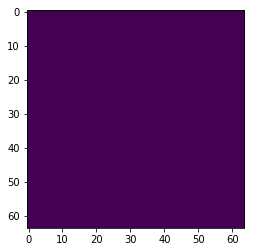

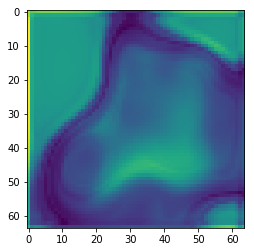

Iter 2400 || Loss: 3.7384 || Mask: 2.9922 || Regr: 0.0746
Iter 2410 || Loss: 2.9142 || Mask: 2.7631 || Regr: 0.0151
Iter 2420 || Loss: 3.5780 || Mask: 3.1859 || Regr: 0.0392
Iter 2430 || Loss: 3.1433 || Mask: 2.8635 || Regr: 0.0280
Iter 2440 || Loss: 4.1851 || Mask: 3.4099 || Regr: 0.0775
Iter 2450 || Loss: 3.6566 || Mask: 3.3107 || Regr: 0.0346
Iter 2460 || Loss: 2.9457 || Mask: 2.7028 || Regr: 0.0243
Iter 2470 || Loss: 3.8434 || Mask: 3.3466 || Regr: 0.0497
Iter 2480 || Loss: 3.5561 || Mask: 3.1329 || Regr: 0.0423
Iter 2490 || Loss: 3.2953 || Mask: 2.8958 || Regr: 0.0399


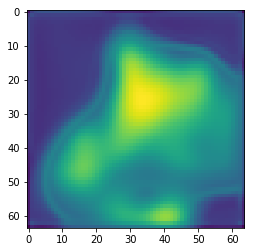

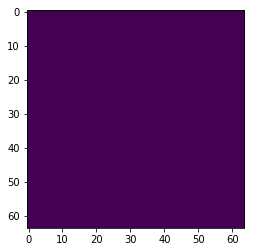

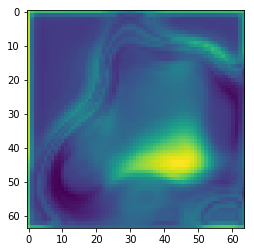

Iter 2500 || Loss: 3.6041 || Mask: 3.1104 || Regr: 0.0494
Iter 2510 || Loss: 3.0937 || Mask: 2.8228 || Regr: 0.0271
Iter 2520 || Loss: 2.8937 || Mask: 2.7056 || Regr: 0.0188
Iter 2530 || Loss: 3.2032 || Mask: 2.7719 || Regr: 0.0431
Iter 2540 || Loss: 4.3911 || Mask: 3.8031 || Regr: 0.0588
Iter 2550 || Loss: 3.5022 || Mask: 3.2376 || Regr: 0.0265
Iter 2560 || Loss: 2.9158 || Mask: 2.7499 || Regr: 0.0166
Iter 2570 || Loss: 3.0172 || Mask: 2.7943 || Regr: 0.0223
Iter 2580 || Loss: 3.5640 || Mask: 3.3428 || Regr: 0.0221
Iter 2590 || Loss: 3.1173 || Mask: 2.8428 || Regr: 0.0275


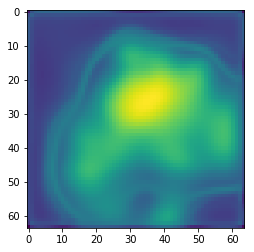

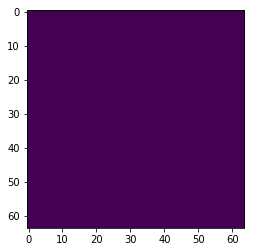

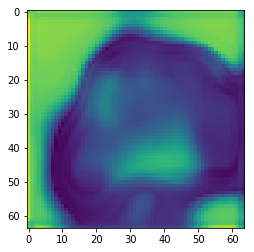

Iter 2600 || Loss: 3.0716 || Mask: 2.7782 || Regr: 0.0293
Iter 2610 || Loss: 3.5739 || Mask: 3.2414 || Regr: 0.0333
Iter 2620 || Loss: 2.9309 || Mask: 2.7065 || Regr: 0.0224
Iter 2630 || Loss: 3.2863 || Mask: 2.7899 || Regr: 0.0496
Iter 2640 || Loss: 2.9029 || Mask: 2.6687 || Regr: 0.0234
Iter 2650 || Loss: 2.5897 || Mask: 2.2926 || Regr: 0.0297
Iter 2660 || Loss: 3.1326 || Mask: 2.9495 || Regr: 0.0183
Iter 2670 || Loss: 3.5023 || Mask: 2.9593 || Regr: 0.0543
Iter 2680 || Loss: 3.2150 || Mask: 2.8701 || Regr: 0.0345
Iter 2690 || Loss: 3.3964 || Mask: 3.2229 || Regr: 0.0173


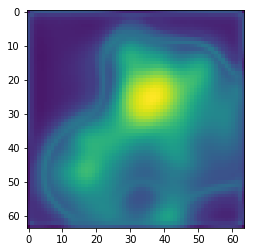

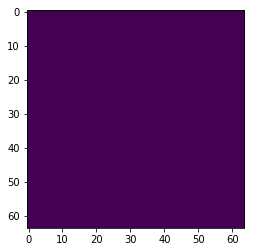

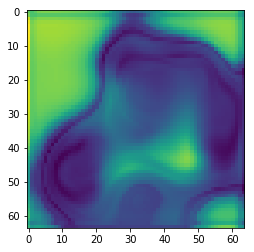

Iter 2700 || Loss: 3.5294 || Mask: 3.2114 || Regr: 0.0318
Iter 2710 || Loss: 2.8343 || Mask: 2.5757 || Regr: 0.0259
Iter 2720 || Loss: 3.7524 || Mask: 3.4701 || Regr: 0.0282
Iter 2730 || Loss: 2.8142 || Mask: 2.6558 || Regr: 0.0158
Iter 2740 || Loss: 3.1742 || Mask: 2.7540 || Regr: 0.0420
Iter 2750 || Loss: 3.2145 || Mask: 2.9849 || Regr: 0.0230
Iter 2760 || Loss: 3.0766 || Mask: 2.8229 || Regr: 0.0254
Iter 2770 || Loss: 3.2569 || Mask: 2.9858 || Regr: 0.0271
Iter 2780 || Loss: 2.7797 || Mask: 2.5246 || Regr: 0.0255
Iter 2790 || Loss: 3.3831 || Mask: 3.0383 || Regr: 0.0345


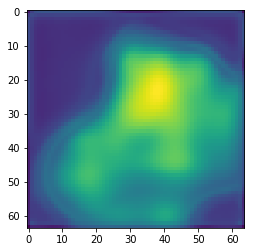

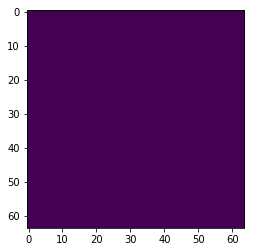

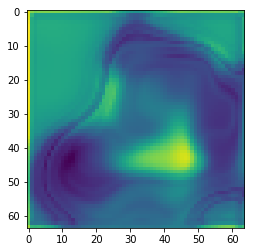

Iter 2800 || Loss: 3.4962 || Mask: 2.9779 || Regr: 0.0518
Iter 2810 || Loss: 3.4998 || Mask: 3.2602 || Regr: 0.0240
Iter 2820 || Loss: 3.2186 || Mask: 2.8912 || Regr: 0.0327
Iter 2830 || Loss: 2.9332 || Mask: 2.6502 || Regr: 0.0283
Iter 2840 || Loss: 2.8040 || Mask: 2.5998 || Regr: 0.0204
Iter 2850 || Loss: 3.2011 || Mask: 2.9319 || Regr: 0.0269
Iter 2860 || Loss: 3.0396 || Mask: 2.8535 || Regr: 0.0186
Iter 2870 || Loss: 3.5681 || Mask: 3.2268 || Regr: 0.0341
Iter 2880 || Loss: 3.0317 || Mask: 2.7577 || Regr: 0.0274
Iter 2890 || Loss: 3.1237 || Mask: 3.0037 || Regr: 0.0120


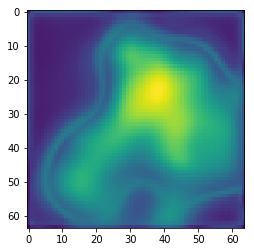

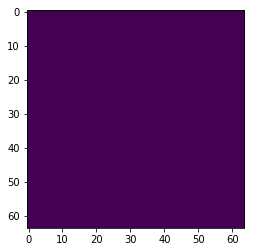

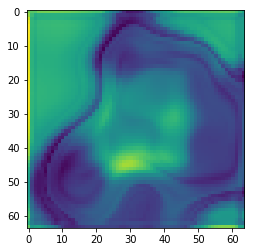

Iter 2900 || Loss: 3.3838 || Mask: 3.0952 || Regr: 0.0289
Iter 2910 || Loss: 3.3171 || Mask: 2.8727 || Regr: 0.0444
Iter 2920 || Loss: 3.2775 || Mask: 3.0093 || Regr: 0.0268
Iter 2930 || Loss: 3.0806 || Mask: 2.7402 || Regr: 0.0340
Iter 2940 || Loss: 3.0200 || Mask: 2.7618 || Regr: 0.0258
Iter 2950 || Loss: 3.6433 || Mask: 3.1640 || Regr: 0.0479
Iter 2960 || Loss: 3.4103 || Mask: 3.1025 || Regr: 0.0308
Iter 2970 || Loss: 2.9927 || Mask: 2.8011 || Regr: 0.0192
Iter 2980 || Loss: 3.4049 || Mask: 3.1191 || Regr: 0.0286
Iter 2990 || Loss: 3.5028 || Mask: 2.8068 || Regr: 0.0696


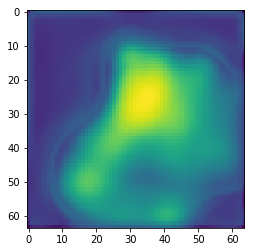

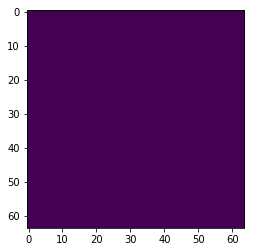

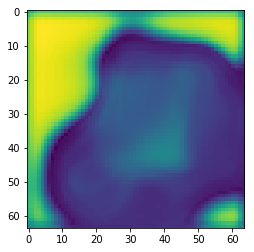

Iter 3000 || Loss: 2.8305 || Mask: 2.6653 || Regr: 0.0165
Iter 3010 || Loss: 2.9661 || Mask: 2.7681 || Regr: 0.0198
Iter 3020 || Loss: 2.8532 || Mask: 2.6622 || Regr: 0.0191
Iter 3030 || Loss: 3.1783 || Mask: 2.8518 || Regr: 0.0327
Iter 3040 || Loss: 3.1971 || Mask: 2.9554 || Regr: 0.0242
Iter 3050 || Loss: 3.1858 || Mask: 2.8943 || Regr: 0.0291
Iter 3060 || Loss: 3.2483 || Mask: 2.8805 || Regr: 0.0368
Iter 3070 || Loss: 3.1389 || Mask: 2.9615 || Regr: 0.0177
Iter 3080 || Loss: 3.0897 || Mask: 2.8661 || Regr: 0.0224
Iter 3090 || Loss: 2.8590 || Mask: 2.6676 || Regr: 0.0191


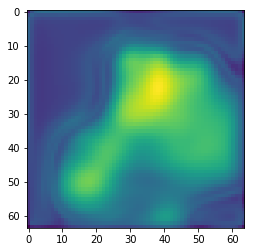

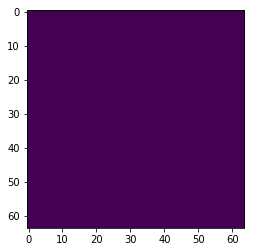

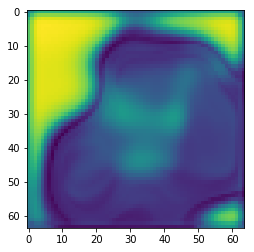

Iter 3100 || Loss: 3.3041 || Mask: 2.9759 || Regr: 0.0328

-------------
epoch 3 || Epoch_TRAIN_Loss:3399.9070 ||Epoch_VAL_Loss:0.0000
timer:  283.5318 sec.
lr is: 0.001
-------------
Epoch 4/150
-------------
(train)


Iter 3110 || Loss: 2.7262 || Mask: 2.5236 || Regr: 0.0203
Iter 3120 || Loss: 3.1719 || Mask: 2.8544 || Regr: 0.0318
Iter 3130 || Loss: 2.6723 || Mask: 2.4910 || Regr: 0.0181
Iter 3140 || Loss: 2.8826 || Mask: 2.5429 || Regr: 0.0340
Iter 3150 || Loss: 3.0580 || Mask: 2.7293 || Regr: 0.0329
Iter 3160 || Loss: 3.4916 || Mask: 3.0039 || Regr: 0.0488
Iter 3170 || Loss: 2.9202 || Mask: 2.8356 || Regr: 0.0085
Iter 3180 || Loss: 3.3403 || Mask: 3.0815 || Regr: 0.0259
Iter 3190 || Loss: 3.6066 || Mask: 3.1583 || Regr: 0.0448


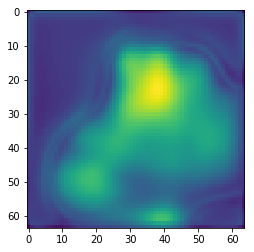

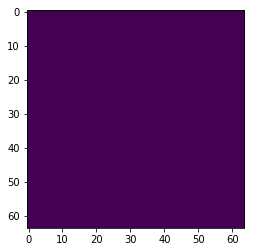

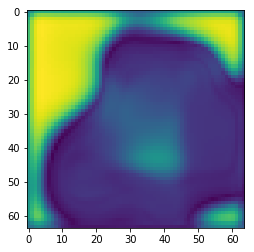

Iter 3200 || Loss: 3.5206 || Mask: 3.1903 || Regr: 0.0330
Iter 3210 || Loss: 2.9947 || Mask: 2.7662 || Regr: 0.0229
Iter 3220 || Loss: 2.9876 || Mask: 2.5176 || Regr: 0.0470
Iter 3230 || Loss: 3.0149 || Mask: 2.7803 || Regr: 0.0235
Iter 3240 || Loss: 2.9864 || Mask: 2.8836 || Regr: 0.0103
Iter 3250 || Loss: 2.8009 || Mask: 2.6176 || Regr: 0.0183
Iter 3260 || Loss: 2.5664 || Mask: 2.3437 || Regr: 0.0223
Iter 3270 || Loss: 3.0655 || Mask: 2.9252 || Regr: 0.0140
Iter 3280 || Loss: 3.2626 || Mask: 2.8540 || Regr: 0.0409
Iter 3290 || Loss: 3.5289 || Mask: 3.0809 || Regr: 0.0448


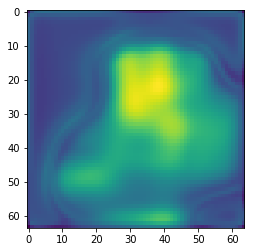

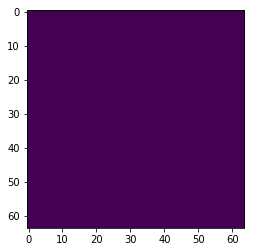

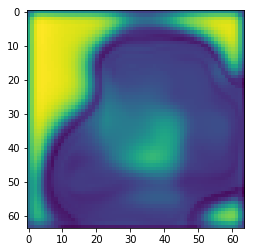

Iter 3300 || Loss: 3.3753 || Mask: 2.9933 || Regr: 0.0382
Iter 3310 || Loss: 2.9139 || Mask: 2.5638 || Regr: 0.0350
Iter 3320 || Loss: 3.0146 || Mask: 2.8272 || Regr: 0.0187
Iter 3330 || Loss: 3.7327 || Mask: 3.3534 || Regr: 0.0379
Iter 3340 || Loss: 2.6542 || Mask: 2.5422 || Regr: 0.0112
Iter 3350 || Loss: 2.4963 || Mask: 2.3413 || Regr: 0.0155
Iter 3360 || Loss: 2.9094 || Mask: 2.6148 || Regr: 0.0295
Iter 3370 || Loss: 3.1258 || Mask: 2.8425 || Regr: 0.0283
Iter 3380 || Loss: 2.6897 || Mask: 2.5001 || Regr: 0.0190
Iter 3390 || Loss: 2.8960 || Mask: 2.6276 || Regr: 0.0268


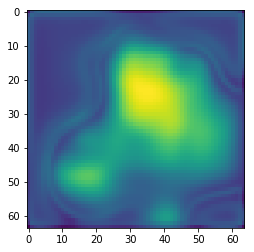

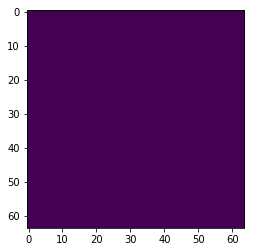

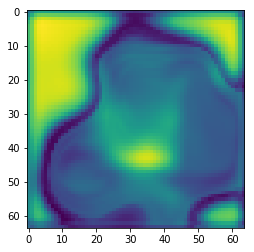

Iter 3400 || Loss: 3.1498 || Mask: 2.9436 || Regr: 0.0206
Iter 3410 || Loss: 3.2985 || Mask: 3.0041 || Regr: 0.0294
Iter 3420 || Loss: 2.8936 || Mask: 2.4355 || Regr: 0.0458
Iter 3430 || Loss: 2.5100 || Mask: 2.3354 || Regr: 0.0175
Iter 3440 || Loss: 2.7842 || Mask: 2.6040 || Regr: 0.0180
Iter 3450 || Loss: 3.0951 || Mask: 2.7557 || Regr: 0.0339
Iter 3460 || Loss: 2.6210 || Mask: 2.3388 || Regr: 0.0282
Iter 3470 || Loss: 2.5295 || Mask: 2.3887 || Regr: 0.0141
Iter 3480 || Loss: 2.8381 || Mask: 2.5973 || Regr: 0.0241
Iter 3490 || Loss: 3.0883 || Mask: 2.6909 || Regr: 0.0397


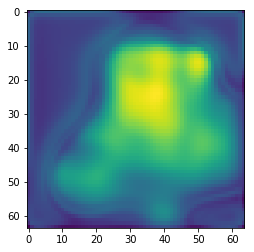

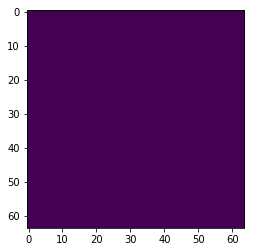

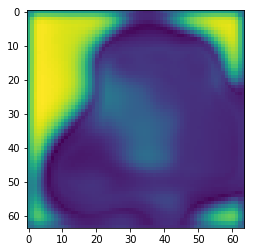

Iter 3500 || Loss: 3.0247 || Mask: 2.8175 || Regr: 0.0207
Iter 3510 || Loss: 3.0151 || Mask: 2.7275 || Regr: 0.0288
Iter 3520 || Loss: 2.7871 || Mask: 2.5123 || Regr: 0.0275
Iter 3530 || Loss: 3.2345 || Mask: 2.9381 || Regr: 0.0296
Iter 3540 || Loss: 2.9302 || Mask: 2.6364 || Regr: 0.0294
Iter 3550 || Loss: 3.2337 || Mask: 2.8206 || Regr: 0.0413
Iter 3560 || Loss: 2.8955 || Mask: 2.6118 || Regr: 0.0284
Iter 3570 || Loss: 3.1573 || Mask: 2.6772 || Regr: 0.0480
Iter 3580 || Loss: 2.9933 || Mask: 2.7694 || Regr: 0.0224
Iter 3590 || Loss: 2.8997 || Mask: 2.5576 || Regr: 0.0342


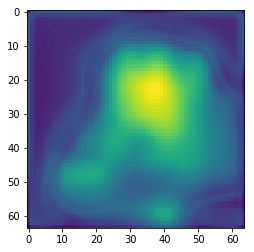

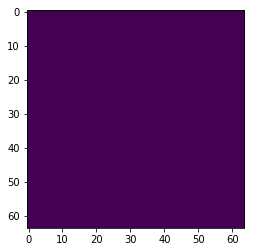

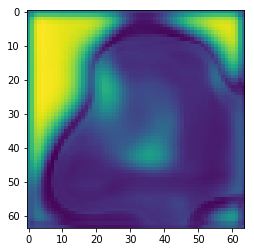

Iter 3600 || Loss: 2.0379 || Mask: 1.9719 || Regr: 0.0066
Iter 3610 || Loss: 2.5330 || Mask: 2.3264 || Regr: 0.0207
Iter 3620 || Loss: 3.3028 || Mask: 3.0213 || Regr: 0.0282
Iter 3630 || Loss: 2.5656 || Mask: 2.4205 || Regr: 0.0145
Iter 3640 || Loss: 2.9759 || Mask: 2.8044 || Regr: 0.0171
Iter 3650 || Loss: 2.9867 || Mask: 2.6346 || Regr: 0.0352
Iter 3660 || Loss: 3.1492 || Mask: 2.8412 || Regr: 0.0308
Iter 3670 || Loss: 2.9983 || Mask: 2.8321 || Regr: 0.0166
Iter 3680 || Loss: 2.4327 || Mask: 2.2761 || Regr: 0.0157
Iter 3690 || Loss: 2.7859 || Mask: 2.6175 || Regr: 0.0168


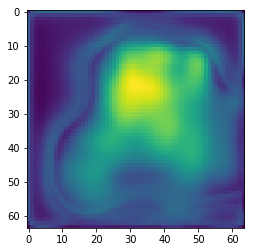

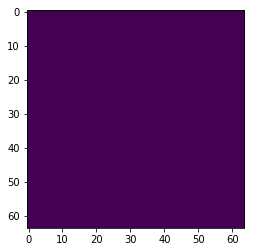

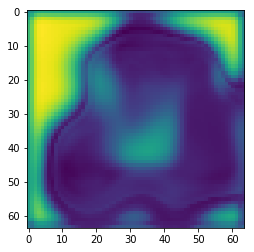

Iter 3700 || Loss: 2.6202 || Mask: 2.3747 || Regr: 0.0246
Iter 3710 || Loss: 2.8499 || Mask: 2.6160 || Regr: 0.0234
Iter 3720 || Loss: 2.6600 || Mask: 2.4511 || Regr: 0.0209
Iter 3730 || Loss: 3.1390 || Mask: 2.7487 || Regr: 0.0390
Iter 3740 || Loss: 3.0418 || Mask: 2.8679 || Regr: 0.0174


In [ ]:
num_epochs = 150
torch.cuda.empty_cache()
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)